In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

from imblearn.over_sampling import SMOTE #for SMOTE -> install package using: conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import RandomOverSampler 
from scipy import stats, integrate
import matplotlib.pyplot as plt
import ggplot
import scipy
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
#from sklearn.svm import SVR #just Testing for regression on other continous data of dataset
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2


import pylab as pl
from itertools import cycle
from sklearn import cross_validation
from sklearn.svm import SVC

features_list = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','class']
dataset1=pd.read_csv("data/Heart_Disease_Data.csv")


/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into whi

In [2]:
# SVM requires that each data instance is represented as a vector of real numbers
# If you already have numeric dtypes (int8|16|32|64,float64,boolean) you can convert it to another "numeric" dtype using Pandas .astype() method. Demo: In [90]: df = pd.DataFrame(np.random.randint(10**5,10**7,(5,3)),columns=list('abc'), dtype=np.int64) In [91]: df Out[91]: a b c 0 9059440 9590567 2076918 1 5861102 4566089 1947323 2 6636568 162770 2487991 3 6794572 5236903 5628779 4 470121 4044395 4546794 In [92]: df.dtypes Out[92]: a int64 b int64 c int64 dtype: object In [93]: df['a'] = df['a'].astype(float) In [94]: df.dtypes Out[94]: a float64 b int64 c int64 dtype: object It won't work for object (string) dtypes, that can't be converted to numbers: In [95]: df.loc[1, 'b'] = 'XXXXXX' In [96]: df Out[96]:...
# Just make everything numeric for ease, later we will convert to ordinal/one-hot encoding.
dataset1 = dataset1.convert_objects(convert_numeric=True)
dataset1 = dataset1.astype('float')

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


#### count missing value in terms of colunms #######

In [3]:
#dataset.shape[0] - dataset.count()
print(dataset1.isnull().any())
dataset1 = dataset1.replace('?', np.nan)

age               False
sex               False
cp                False
trestbps          False
chol              False
fbs               False
restecg           False
thalach           False
exang             False
oldpeak           False
slop              False
ca                 True
thal               True
pred_attribute    False
dtype: bool


#### check for duplications

In [4]:
dataset1.duplicated().any()

False

In [5]:
# based on https://pdfs.semanticscholar.org/daa0/f01f96a89fcfc5f41a2da67fb2a8966900ab.pdf 
# we should pick these features:
Genetic_Based_Decision = dataset1[['cp','trestbps', 'restecg', 'thalach', 'ca', 'thal']]

In [6]:
continuous_vars = dataset1[['age', 'restecg', 'chol', 'thalach', 'oldpeak']] 

def checkforoutlier(df):
    outliersnumbers = 0
    for column in df:
        for number in df[column]:
            if number < np.percentile(
                df[column], 25)-(np.percentile(
                df[column], 75)-np.percentile(
                df[column], 25)) or number > np.percentile(
                df[column], 75)+(np.percentile(
                df[column], 75)-np.percentile(
                df[column], 25)):
                    print("outlier: ", number, column)
                    outliersnumbers += 1
    return outliersnumbers, 'outliers. That is', round(float(outliersnumbers)/float(len(df[column]))*100, 0), 'percent of the total list'

print(checkforoutlier(continuous_vars))

# Thalach seems very high, but after research a heartbeat of 202 is possible: 

outlier:  34.0 age
outlier:  29.0 age
outlier:  77.0 age
outlier:  34.0 age
outlier:  76.0 age
outlier:  354.0 chol
outlier:  340.0 chol
outlier:  353.0 chol
outlier:  417.0 chol
outlier:  360.0 chol
outlier:  141.0 chol
outlier:  341.0 chol
outlier:  407.0 chol
outlier:  564.0 chol
outlier:  394.0 chol
outlier:  409.0 chol
outlier:  126.0 chol
outlier:  342.0 chol
outlier:  131.0 chol
outlier:  99.0 thalach
outlier:  97.0 thalach
outlier:  202.0 thalach
outlier:  96.0 thalach
outlier:  88.0 thalach
outlier:  95.0 thalach
outlier:  96.0 thalach
outlier:  71.0 thalach
outlier:  90.0 thalach
outlier:  3.5 oldpeak
outlier:  3.6 oldpeak
outlier:  3.4 oldpeak
outlier:  3.6 oldpeak
outlier:  6.2 oldpeak
outlier:  3.6 oldpeak
outlier:  4.0 oldpeak
outlier:  5.6 oldpeak
outlier:  4.0 oldpeak
outlier:  4.2 oldpeak
outlier:  4.2 oldpeak
outlier:  3.8 oldpeak
outlier:  3.4 oldpeak
outlier:  3.6 oldpeak
outlier:  4.4 oldpeak
outlier:  4.0 oldpeak
outlier:  3.4 oldpeak
(45, 'outliers. That is', 15.

In [7]:
# Two variables are discrete/ordinal: ca (number of major vessels colored by fluoroscopy) and num (diagnosis of heart disease)
# Three can be directly viewed as 1 hot (because binary): 'sex':'male', 'fbs':'fasting blood sugar', 'exang':'exercise induced angina'

# which leaves 4 for one-hot encoding. problem is that the values aren't unique, so have to manually
# make extra columns:

dataset1["cp"] = dataset1["cp"].replace([1,2,3,4], ["typical angina", "atypical angina", "non-angina", "asymptomatic angina"])
dataset1["restecg"] = dataset1["restecg"].replace([0,1,2], ["normalresecg", "ST-T wave abnormality", "left ventricular hypertrophy"])
dataset1["slop"] = dataset1["slop"].replace([1,2,3], ["upsloping", "flat", "downsloping"])
dataset1["thal"] = dataset1["thal"].replace([3,6,7], ["normalthal", "fixed defect", "reversible defect"])

x = dataset1[['cp', 'restecg', 'slop', 'thal']]
for column in ['cp', 'restecg', 'slop', 'thal']:
    one_hot = pd.get_dummies(dataset1[column])
    dataset1 = dataset1.drop(column, axis=1)
    dataset1 = dataset1.join(one_hot)

In [8]:
### Extract features and labels from dataset for local testing:
dataset1.dropna(inplace=True, axis=0, how="any")
Y=dataset1["pred_attribute"]
dataset1 = dataset1.drop("pred_attribute", axis=1)
X=dataset1

In [9]:
# evaluate the model by splitting into train and test sets  #Edit by ryan, we aim to do 3 traditional sets in the end, this first split is 80/20
features_train, features_test, labels_train, labels_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [10]:
import collections

list1 = []
for i in labels_train:
    list1.append(i)
counter=collections.Counter(list1)
print(counter)

list2 = []
for i in labels_test:
    list2.append(i)
counter=collections.Counter(list2)
print(counter)

Counter({0.0: 116, 1.0: 33, 3.0: 29, 2.0: 23, 4.0: 8})
Counter({0.0: 45, 1.0: 21, 2.0: 13, 3.0: 6, 4.0: 5})


In [11]:
# Check
print(len(features_train)/(len(features_train)+ len(features_test)))

0.6989966555183946


In [12]:
features_train_df = pd.DataFrame(features_train)
features_train_df.to_csv('features_train.csv', index=False)

features_test_df = pd.DataFrame(features_test)
features_test_df.to_csv('features_test.csv', index=False)

labels_train_df = pd.DataFrame(labels_train)
labels_train_df.to_csv('labels_train.csv', index=False)

labels_test_df = pd.DataFrame(labels_test)
labels_test_df.to_csv('labels_test.csv', index=False)

## Feature Importance Scores based on XGBoost (by David)

In [13]:
import xgboost as xgb
import operator

xgb_params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'lambda': 0.8,   
    'alpha': 0.4,
    'silent': 1,
    'num_class': 5
}

dtrain = xgb.DMatrix(features_train, labels_train)
dtest = xgb.DMatrix(features_test, labels_test)

num_boost_rounds = 250

watchlist = [(dtrain, 'train'), (dtest, 'test')]

# train model
xgb_model = xgb.train(xgb_params, dtrain, num_boost_rounds, watchlist)

[0]	train-mlogloss:1.56068	test-mlogloss:1.58128
[1]	train-mlogloss:1.51669	test-mlogloss:1.55728
[2]	train-mlogloss:1.47704	test-mlogloss:1.53337
[3]	train-mlogloss:1.43637	test-mlogloss:1.50983
[4]	train-mlogloss:1.39902	test-mlogloss:1.4884
[5]	train-mlogloss:1.36248	test-mlogloss:1.46833
[6]	train-mlogloss:1.32811	test-mlogloss:1.44857
[7]	train-mlogloss:1.29549	test-mlogloss:1.43041
[8]	train-mlogloss:1.26439	test-mlogloss:1.41397
[9]	train-mlogloss:1.23422	test-mlogloss:1.39903
[10]	train-mlogloss:1.2058	test-mlogloss:1.3858
[11]	train-mlogloss:1.1784	test-mlogloss:1.37447
[12]	train-mlogloss:1.15217	test-mlogloss:1.3623
[13]	train-mlogloss:1.12708	test-mlogloss:1.35108
[14]	train-mlogloss:1.10233	test-mlogloss:1.34016
[15]	train-mlogloss:1.07996	test-mlogloss:1.3293
[16]	train-mlogloss:1.05729	test-mlogloss:1.32144
[17]	train-mlogloss:1.03595	test-mlogloss:1.31458
[18]	train-mlogloss:1.01542	test-mlogloss:1.30547
[19]	train-mlogloss:0.996551	test-mlogloss:1.29759
[20]	train-mlog

[161]	train-mlogloss:0.216928	test-mlogloss:1.23914
[162]	train-mlogloss:0.21557	test-mlogloss:1.23952
[163]	train-mlogloss:0.214313	test-mlogloss:1.2406
[164]	train-mlogloss:0.213269	test-mlogloss:1.24208
[165]	train-mlogloss:0.211917	test-mlogloss:1.24394
[166]	train-mlogloss:0.210629	test-mlogloss:1.24412
[167]	train-mlogloss:0.209386	test-mlogloss:1.24494
[168]	train-mlogloss:0.208099	test-mlogloss:1.24586
[169]	train-mlogloss:0.206741	test-mlogloss:1.24701
[170]	train-mlogloss:0.205412	test-mlogloss:1.24727
[171]	train-mlogloss:0.204191	test-mlogloss:1.24778
[172]	train-mlogloss:0.203048	test-mlogloss:1.24835
[173]	train-mlogloss:0.201742	test-mlogloss:1.24844
[174]	train-mlogloss:0.200615	test-mlogloss:1.24934
[175]	train-mlogloss:0.199453	test-mlogloss:1.25006
[176]	train-mlogloss:0.198429	test-mlogloss:1.25111
[177]	train-mlogloss:0.197348	test-mlogloss:1.25259
[178]	train-mlogloss:0.196295	test-mlogloss:1.25329
[179]	train-mlogloss:0.195122	test-mlogloss:1.25389
[180]	train-ml

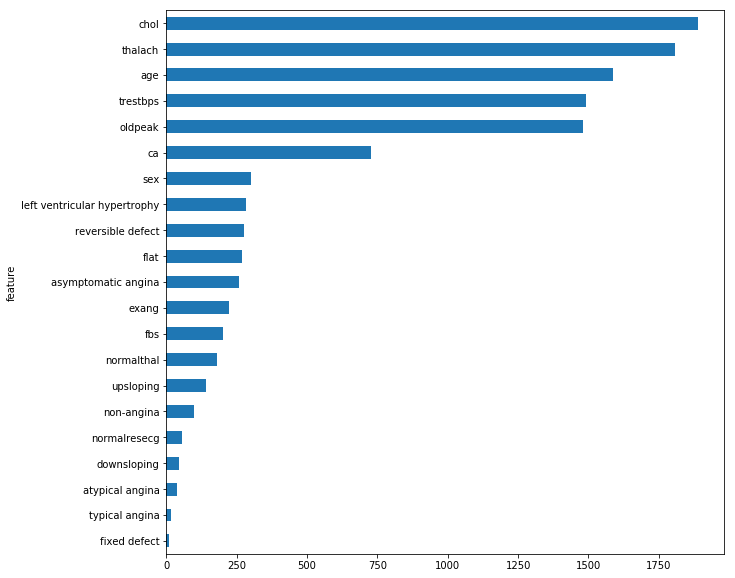

In [14]:
importance = xgb_model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])

# Plot Feature Importance
plt.figure()
importance_df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 10))

In [15]:
def feature_selection(dataframe, importance_scores_df, threshold=0.4):
    normalized_df = importance_scores_df.copy()
    normalized_df['fscore'] = (importance_scores_df['fscore'] - importance_scores_df['fscore'].min())/(importance_scores_df['fscore'].max()-importance_scores_df['fscore'].min())
    normalized_df = normalized_df[normalized_df['fscore'] >= threshold]
    new_dataframe = dataframe.filter(items=normalized_df['feature'].tolist())
    return new_dataframe

features_train_009_df = feature_selection(features_train_df, importance_df, threshold=0.09)
features_train_009 = features_train_009_df.as_matrix()
features_train_04_df = feature_selection(features_train_df, importance_df, threshold=0.4)
features_train_04 = features_train_04_df.as_matrix()

features_test_009_df = feature_selection(features_test_df, importance_df, threshold=0.09)
features_test_009 = features_test_009_df.as_matrix()
features_test_04_df = feature_selection(features_test_df, importance_df, threshold=0.4)
features_test_04 = features_test_04_df.as_matrix()

## Principal Component Analysis 

In [16]:
from numpy import linalg as LA

def eigen_scores(dataframe):
    dataframe-=np.mean(dataframe, axis=0)
    dataframe/=np.std(dataframe, axis=0)
    cov_mat=np.cov(dataframe, rowvar=False)
    evals, evecs = np.linalg.eigh(cov_mat)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]
    return evals, evecs

def my_pca(dataframe, n_components):
    pca=PCA(n_components=n_components)
    return pca.fit_transform(dataframe)



eigenvalues, eigenvectors = eigen_scores(features_test_04.copy())
n_components_04 = len(np.where(eigenvalues >= 1)[0])
print("Number of components for Dataset with threshold=0.4 is {}".format(n_components_04))

features_train_04_pca = my_pca(features_train_04, n_components_04)
features_test_04_pca = my_pca(features_test_04, n_components_04)

eigenvalues, eigenvectors = eigen_scores(features_test_009.copy())
n_components_009 = len(np.where(eigenvalues >= 1)[0])
print("Number of components for Dataset with threshold=0.09 is {}".format(n_components_009))

features_train_009_pca = my_pca(features_train_009, n_components_009)
features_test_009_pca = my_pca(features_test_009, n_components_009)

Number of components for Dataset with threshold=0.4 is 2
Number of components for Dataset with threshold=0.09 is 5


# Modelling And Training

We have an relatively small dataset. Therefore, we should do our feature selection based on a cross-
validated set. 

### SMOTE for SVM - Balancing only on the training set, not the validation set  [This is for the traditional training -not the cross validated one]

In [17]:
#further divide the 'traditional' non-cross set into training 80/20  for pure training and cross validation  
features_train_notoversampled, features_validate, labels_train_notoversampled, labels_validate = train_test_split(features_train, labels_train, test_size = .2, random_state=0)

sm = SMOTE(random_state=0, ratio = 1.0, kind= 'svm' )
#x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
features_train_oversampled, labels_train_oversampled = sm.fit_sample(features_train_notoversampled, labels_train_notoversampled)

#re-enter into original variables
##features_train = features_train_oversampled
##labels_train = labels_train_oversampled

#Below 2 lines if we want to want to force the array back into dataframe    
##features_train = pd.DataFrame(features_train_oversampled,columns=["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slop","ca","thal"])
##labels_train = pd.DataFrame(labels_train_oversampled,columns=["pred_attribute"])

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


## Standard Scaler (by David)
SVC Models are only any good when the data is scaled. Lets scale the data and build the model

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer

scaler = MinMaxScaler()
Standard_scaler = StandardScaler()
Robust_scaler = preprocessing.RobustScaler(quantile_range=(25, 75))
Quantile_scalar = preprocessing.QuantileTransformer(output_distribution='normal')

features_train = Standard_scaler.fit_transform(features_train)
features_test = Standard_scaler.transform(features_test)

features_train_009 = Standard_scaler.fit_transform(features_train_009)
features_test_009 = Standard_scaler.transform(features_test_009)

features_train_04 = Standard_scaler.fit_transform(features_train_04)
features_test_04 = Standard_scaler.transform(features_test_04)

features_train_009_pca = Standard_scaler.fit_transform(features_train_009_pca)
features_test_009_pca = Standard_scaler.transform(features_test_009_pca)

features_train_04_pca = Standard_scaler.fit_transform(features_train_04_pca)
features_test_04_pca = Standard_scaler.transform(features_test_04_pca)

# Balancing only on the training set, not the validation set
Unfortunately SMOTE categorial implementation is not really implemented
We will do undersampling of majority AND oversampling of minority -> Done using external program SPSS 

In [19]:
# Export data to files for external program to balance the data

# without features selection
train = np.concatenate((features_train, labels_train.values.reshape((-1, 1))), axis=1)
train_df = pd.DataFrame(train) 
train_df.to_csv("Undata/train_NoEng_NB.csv", index=False)

# train_009
train_009 = np.concatenate((features_train_009, labels_train.values.reshape((-1, 1))), axis=1)
train_009_df = pd.DataFrame(train_009) 
train_009_df.to_csv("Undata/train_009_NB.csv", index=False) 
    
# train_04 
train_04 = np.concatenate((features_train_04, labels_train.values.reshape((-1, 1))), axis=1)
train_04_df = pd.DataFrame(train_04) 
train_04_df.to_csv("Undata/train_04_NB.csv", index=False)

# train_009_pca 
train_009_pca = np.concatenate((features_train_009_pca, labels_train.values.reshape((-1, 1))), axis=1)
train_009_pca_df = pd.DataFrame(train_009_pca) 
train_009_pca_df.to_csv("Undata/train_009_pca_NB.csv", index=False)

# train_04_pca
train_04_pca = np.concatenate((features_train_04_pca, labels_train.values.reshape((-1, 1))), axis=1)
train_04_pca_df = pd.DataFrame(train_04_pca) 
train_04_pca_df.to_csv("Undata/train_04_pca_NB.csv", index=False)

In [20]:
# without features selection
train_noEng_df = pd.read_csv("Bdata/train_noEng_Balanced2.csv")
labels_train_noEng = train_noEng_df["22"]
train_noEng_df = train_noEng_df.drop("22", axis=1)
features_train_noEng = train_noEng_df.as_matrix()
print(features_train_noEng)

# train_009
train_009_df = pd.read_csv("Bdata/train_009_B2.csv")
labels_train_009 = train_009_df["14"]
train_009_df = train_009_df.drop("14", axis=1)
features_train_009 = train_009_df.as_matrix()

# train_04 
train_04_df = pd.read_csv("Bdata/train_04_B2.csv")
labels_train_04 = train_04_df["5"]
train_04_df = train_04_df.drop("5", axis=1)
features_train_04 = train_04_df.as_matrix()

# train_009_pca 
train_009_pca_df = pd.read_csv("Bdata/train_009_PCA_B2.csv")
labels_train_009_pca = train_009_pca_df["5"]
train_009_pca_df = train_009_pca_df.drop("5", axis=1)
features_train_009_pca = train_009_pca_df.as_matrix()

# train_04_pca
train_04_pca_df = pd.read_csv("Bdata/train_04_PCA_B2.csv")
labels_train_04_pca = train_04_pca_df["2"]
train_04_pca_df = train_04_pca_df.drop("2", axis=1)
features_train_04_pca = train_04_pca_df.as_matrix()

[[-2.052728  0.694456 -0.59914  ... -0.199502  0.939618 -0.852803]
 [ 0.731031 -1.439975 -0.162452 ... -0.199502  0.939618 -0.852803]
 [ 0.731031 -1.439975 -0.162452 ... -0.199502  0.939618 -0.852803]
 ...
 [-0.446713  0.694456  0.929268 ... -0.199502 -1.064262  1.172604]
 [-0.446713  0.694456  0.929268 ... -0.199502 -1.064262  1.172604]
 [ 0.838099 -1.439975  0.383408 ... -0.199502  0.939618 -0.852803]]


In [21]:
features_train_009

array([[ 0.939618, -0.409387, -0.702038, ..., -2.052728,  1.032032,
        -1.065466],
       [ 0.939618, -0.409387, -0.702038, ...,  0.731031,  0.818895,
         1.465015],
       [ 0.939618, -0.409387, -0.702038, ...,  0.731031,  0.818895,
         1.465015],
       ...,
       [-1.064262, -0.409387, -0.702038, ..., -0.446713, -0.928829,
        -0.130288],
       [-1.064262, -0.409387, -0.702038, ..., -0.446713, -0.928829,
        -0.130288],
       [ 0.939618, -0.409387, -0.702038, ...,  0.838099,  0.307366,
         2.638572]])

In [22]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
#from sklearn import grid_search
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import reciprocal, uniform

def checkmetrics(pred, labels_test, name):
    sns.set()
    print('The accuracy of ', name, 'is: ', accuracy_score(pred, labels_test))
    matrix = confusion_matrix(labels_test, pred)
    ax = sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    print(ax)
    print(classification_report(pred, labels_test))

## Feature selection?

In [23]:
# # Feature selection using RFECV to pick best features,
# from sklearn.svm import SVR
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import RandomizedLasso
# from sklearn.feature_selection import RFECV
# rlasso = RandomizedLasso(alpha=0.025)
# names = features_list
# rlasso.fit(features_train, labels_train)
 
# print("Features sorted by their score using lasso:")
# print(sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
#                  names), reverse=True))

# #use linear regression as the model
# lr = LinearRegression()
# #rank all features, i.e continue the elimination until the last one
# rfe = RFE(lr, n_features_to_select=1)
# rfe.fit(X,Y)
 
# print("Features sorted by their score using Linear Regression:")
# print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))

## Modelling with HyperParameters -Tuning - Default Dataset

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


[Parallel(n_jobs=-1)]: Done 420 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 6750 out of 6750 | elapsed:    7.7s finished
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


The train score: 0.7033492822966507 with parameters: {'C': 2.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'tol': 0.0001}
The accuracy of  C-Support Vector Classification is:  0.5222222222222223
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.96      0.65      0.77        66
        1.0       0.05      0.50      0.09         2
        2.0       0.00      0.00      0.00         1
        3.0       0.50      0.14      0.22        21
        4.0       0.00      0.00      0.00         0

avg / total       0.82      0.52      0.62        90



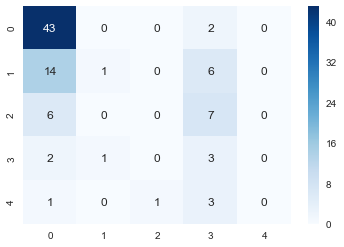

In [24]:
#svm.SVC  C-Support Vector Classification.
parameters ={
         'C': [0.005,0.01,0.05,0.1,0.25,0.5,0.75,1.0,2.0],
         'kernel': ['linear','poly','rbf'],
         'degree': [2,3,4,5,6],
        'gamma': [1e-3,1e-2,1,2,'auto'],
        'tol' : [1e-4],
        'decision_function_shape' : ['ovo','ovr'],
        }
SVM = svm.SVC()

grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train, labels_train)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train, labels_train)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test)

checkmetrics(pred, labels_test, 'C-Support Vector Classification')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.5s finished


The train score: 0.6889952153110048 with parameters: {'C': 0.05, 'max_iter': 1000, 'multi_class': 'crammer_singer', 'random_state': 42, 'tol': 0.0001}
The accuracy of  Linear Support Vector Classification is:  0.5111111111111111
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.96      0.65      0.77        66
        1.0       0.05      0.25      0.08         4
        2.0       0.08      0.20      0.11         5
        3.0       0.17      0.07      0.10        14
        4.0       0.00      0.00      0.00         1

avg / total       0.73      0.51      0.59        90



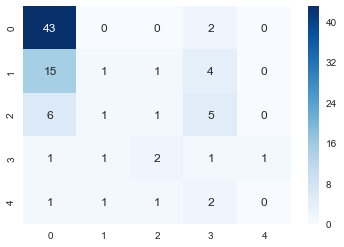

In [25]:
#LinearSVC Linear Support Vector Classification

parameters ={
#       'penalty' : ['l2'], #Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.
#       'loss' : ['squared_hinge'], #Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss.
#        dual' : ['False'], #Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features.
        'tol' : [1e-5,1e-4,1e-3],
        'C': [0.05,0.1,0.5,0.8,1.0,2.0,5.0,10.0,15.0],
        'multi_class'  : ['ovr','crammer_singer'],
        'random_state' : [42],
        'tol' : [1e-4],
        'max_iter' : [1000],
        }
SVM = LinearSVC()
grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train, labels_train)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train, labels_train)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test)

checkmetrics(pred, labels_test, 'Linear Support Vector Classification')

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed:    3.6s finished
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


The train score: 0.14354066985645933 with parameters: {'decision_function_shape': 'ovo', 'degree': 5, 'gamma': 1e-05, 'kernel': 'poly', 'nu': 0.1, 'tol': 0.0001}
The accuracy of  Nu-Support Vector Classification is:  0.12222222222222222
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         3
        1.0       0.00      0.00      0.00         0
        2.0       0.85      0.13      0.22        85
        3.0       0.00      0.00      0.00         2
        4.0       0.00      0.00      0.00         0

avg / total       0.80      0.12      0.21        90



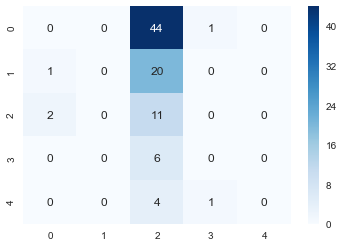

In [26]:
# sklearn.svm.NuSVC Nu-Support Vector Classification
# defaults: nu=0.5, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)
parameters = {
    'nu': [0.001,0.0025,0.005,0.0075,0.1], #other larger nu values is "not fleasible"
    'kernel': ['linear','poly','rbf'],
    'degree': [2,3,4,5,6],
    'gamma': [1e-5,1e-4,1e-3,1e-2,'auto'],
    'tol' : [1e-4],
    'decision_function_shape' : ['ovo','ovr'],

}


SVM = NuSVC()
grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train, labels_train)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train, labels_train)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test)

checkmetrics(pred, labels_test, 'Nu-Support Vector Classification')


# Using Important Features with threshold >= 0.4 (XGB)

### XGB1 

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 5032 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 6750 out of 6750 | elapsed:   28.9s finished


The train score: 0.8123924268502581 with parameters: {'C': 2.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'tol': 0.0001}
The accuracy of  C-Support Vector Classification is:  0.43333333333333335
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.67      0.70      0.68        43
        1.0       0.19      0.22      0.21        18
        2.0       0.08      0.08      0.08        13
        3.0       0.33      0.17      0.22        12
        4.0       0.40      0.50      0.44         4

avg / total       0.43      0.43      0.43        90



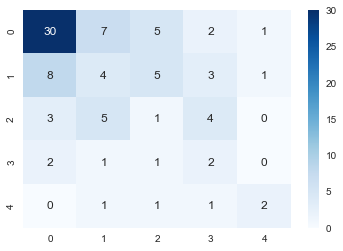

In [27]:
#svm.SVC  C-Support Vector Classification.
parameters ={
         'C': [0.005,0.01,0.05,0.1,0.25,0.5,0.75,1.0,2.0],
         'kernel': ['linear','poly','rbf'],
         'degree': [2,3,4,5,6],
        'gamma': [1e-3,1e-2,1,2,'auto'],
        'tol' : [1e-4],
        'decision_function_shape' : ['ovo','ovr'],
        }
SVM = svm.SVC()

grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train_04, labels_train_04)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train_04, labels_train_04)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test_04)

checkmetrics(pred, labels_test, 'C-Support Vector Classification')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   30.9s finished


The train score: 0.3304647160068847 with parameters: {'C': 0.05, 'max_iter': 1000, 'multi_class': 'crammer_singer', 'random_state': 42, 'tol': 0.0001}
The accuracy of  Linear Support Vector Classification is:  0.4111111111111111
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.71      0.68      0.70        47
        1.0       0.05      0.20      0.08         5
        2.0       0.15      0.22      0.18         9
        3.0       0.00      0.00      0.00         7
        4.0       0.40      0.09      0.15        22

avg / total       0.49      0.41      0.42        90



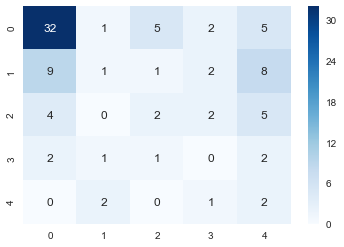

In [28]:
#LinearSVC Linear Support Vector Classification

parameters ={
#       'penalty' : ['l2'], #Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.
#       'loss' : ['squared_hinge'], #Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss.
#        dual' : ['False'], #Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features.
        'tol' : [1e-5,1e-4,1e-3],
        'C': [0.05,0.1,0.5,0.8,1.0,2.0,5.0,10.0,15.0],
        'multi_class'  : ['ovr','crammer_singer'],
        'random_state' : [42],
        'tol' : [1e-4],
        'max_iter' : [1000],
        }
SVM = LinearSVC()
grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train_04, labels_train_04)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train_04, labels_train_04)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test_04)

checkmetrics(pred, labels_test, 'Linear Support Vector Classification')

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed:    4.4s finished


The train score: 0.9500860585197934 with parameters: {'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001, 'tol': 0.0001}
The accuracy of  Nu-Support Vector Classification is:  0.43333333333333335
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.71      0.60      0.65        53
        1.0       0.05      0.25      0.08         4
        2.0       0.23      0.19      0.21        16
        3.0       0.17      0.08      0.11        12
        4.0       0.40      0.40      0.40         5

avg / total       0.51      0.43      0.46        90



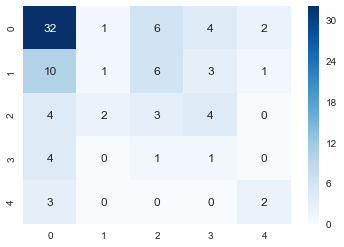

In [29]:
# sklearn.svm.NuSVC Nu-Support Vector Classification
# defaults: nu=0.5, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)
parameters = {
    'nu': [0.001,0.0025,0.005,0.0075,0.1], #other larger nu values is "not fleasible"
    'kernel': ['linear','poly','rbf'],
    'degree': [2,3,4,5,6],
    'gamma': [1e-5,1e-4,1e-3,1e-2,'auto'],
    'tol' : [1e-4],
    'decision_function_shape' : ['ovo','ovr'],

}


SVM = NuSVC()
grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train_04, labels_train_04)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train_04, labels_train_04)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test_04)

checkmetrics(pred, labels_test, 'Nu-Support Vector Classification')


# Using Important Features with threshold >= 0.09 (XGB)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 5032 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 6750 out of 6750 | elapsed:   27.1s finished


The train score: 0.967409948542024 with parameters: {'C': 2.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'tol': 0.0001}
The accuracy of  C-Support Vector Classification is:  0.5333333333333333
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.87      0.70      0.77        56
        1.0       0.24      0.38      0.29        13
        2.0       0.15      0.22      0.18         9
        3.0       0.33      0.18      0.24        11
        4.0       0.00      0.00      0.00         1

avg / total       0.63      0.53      0.57        90



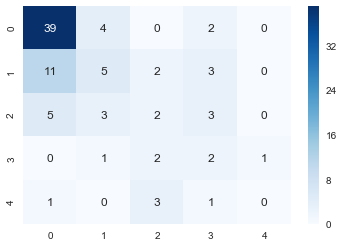

In [30]:
#svm.SVC  C-Support Vector Classification.
parameters ={
         'C': [0.005,0.01,0.05,0.1,0.25,0.5,0.75,1.0,2.0],
         'kernel': ['linear','poly','rbf'],
         'degree': [2,3,4,5,6],
        'gamma': [1e-3,1e-2,1,2,'auto'],
        'tol' : [1e-4],
        'decision_function_shape' : ['ovo','ovr'],
        }
SVM = svm.SVC()

grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train_009, labels_train_009)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train_009, labels_train_009)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test_009)

checkmetrics(pred, labels_test, 'C-Support Vector Classification')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.1s finished


The train score: 0.6260720411663808 with parameters: {'C': 0.8, 'max_iter': 1000, 'multi_class': 'crammer_singer', 'random_state': 42, 'tol': 0.0001}
The accuracy of  Linear Support Vector Classification is:  0.5333333333333333
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.82      0.77      0.80        48
        1.0       0.10      0.25      0.14         8
        2.0       0.38      0.28      0.32        18
        3.0       0.17      0.17      0.17         6
        4.0       0.60      0.30      0.40        10

avg / total       0.60      0.53      0.56        90



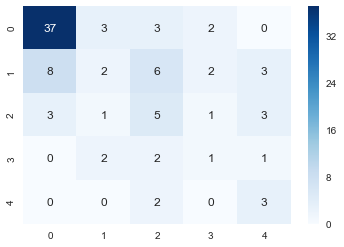

In [31]:
#LinearSVC Linear Support Vector Classification

parameters ={
#       'penalty' : ['l2'], #Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.
#       'loss' : ['squared_hinge'], #Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss.
#        dual' : ['False'], #Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features.
        'tol' : [1e-5,1e-4,1e-3],
        'C': [0.05,0.1,0.5,0.8,1.0,2.0,5.0,10.0,15.0],
        'multi_class'  : ['ovr','crammer_singer'],
        'random_state' : [42],
        'tol' : [1e-4],
        'max_iter' : [1000],
        }
SVM = LinearSVC()
grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train_009, labels_train_009)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train_009, labels_train_009)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test_009)

checkmetrics(pred, labels_test, 'Linear Support Vector Classification')

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Done 316 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed:    7.3s finished


The train score: 0.9656946826758147 with parameters: {'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'nu': 0.001, 'tol': 0.0001}
The accuracy of  Nu-Support Vector Classification is:  0.5111111111111111
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.87      0.67      0.76        58
        1.0       0.14      0.33      0.20         9
        2.0       0.15      0.15      0.15        13
        3.0       0.17      0.12      0.14         8
        4.0       0.20      0.50      0.29         2

avg / total       0.61      0.51      0.55        90



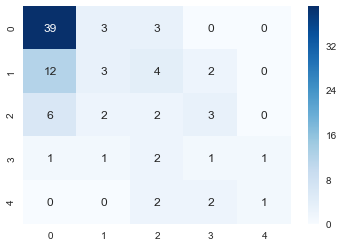

In [32]:
# sklearn.svm.NuSVC Nu-Support Vector Classification
# defaults: nu=0.5, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)
parameters = {
    'nu': [0.001,0.0025,0.005,0.0075,0.1], #other larger nu values is "not fleasible"
    'kernel': ['linear','poly','rbf'],
    'degree': [2,3,4,5,6],
    'gamma': [1e-5,1e-4,1e-3,1e-2,'auto'],
    'tol' : [1e-4],
    'decision_function_shape' : ['ovo','ovr'],

}


SVM = NuSVC()
grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train_009, labels_train_009)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train_009, labels_train_009)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test_009)

checkmetrics(pred, labels_test, 'Nu-Support Vector Classification')


# Using PCA with Important Features (threshold >= 0.09) (XGB)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1696 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 4196 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 6750 out of 6750 | elapsed:   26.5s finished


The train score: 0.8347676419965576 with parameters: {'C': 2.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'tol': 0.0001}
The accuracy of  C-Support Vector Classification is:  0.28888888888888886
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.44      0.54      0.49        37
        1.0       0.19      0.20      0.20        20
        2.0       0.08      0.14      0.10         7
        3.0       0.17      0.05      0.08        19
        4.0       0.00      0.00      0.00         7

avg / total       0.27      0.29      0.27        90



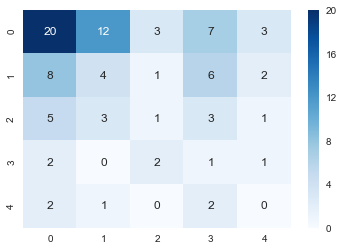

In [33]:
#svm.SVC  C-Support Vector Classification.
parameters ={
         'C': [0.005,0.01,0.05,0.1,0.25,0.5,0.75,1.0,2.0],
         'kernel': ['linear','poly','rbf'],
         'degree': [2,3,4,5,6],
        'gamma': [1e-3,1e-2,1,2,'auto'],
        'tol' : [1e-4],
        'decision_function_shape' : ['ovo','ovr'],
        }
SVM = svm.SVC()

grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train_009_pca, labels_train_009_pca)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train_009_pca, labels_train_009_pca)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test_009_pca)

checkmetrics(pred, labels_test, 'C-Support Vector Classification')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.4s finished


The train score: 0.38209982788296043 with parameters: {'C': 0.8, 'max_iter': 1000, 'multi_class': 'crammer_singer', 'random_state': 42, 'tol': 0.0001}
The accuracy of  Linear Support Vector Classification is:  0.32222222222222224
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.58      0.54      0.56        48
        1.0       0.00      0.00      0.00         3
        2.0       0.08      0.07      0.07        15
        3.0       0.00      0.00      0.00        10
        4.0       0.40      0.14      0.21        14

avg / total       0.38      0.32      0.34        90



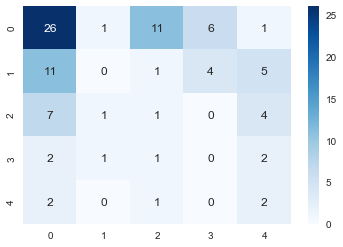

In [34]:
#LinearSVC Linear Support Vector Classification

parameters ={
#       'penalty' : ['l2'], #Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.
#       'loss' : ['squared_hinge'], #Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss.
#        dual' : ['False'], #Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features.
        'tol' : [1e-4],
        'C': [0.05,0.1,0.5,0.8,1.0,2.0,5.0,10.0,15.0],
        'multi_class'  : ['ovr','crammer_singer'],
        'random_state' : [42],
        'tol' : [1e-4],
        'max_iter' : [1000],
        }
SVM = LinearSVC()
grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train_009_pca, labels_train_009_pca)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train_009_pca, labels_train_009_pca)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test_009_pca)

checkmetrics(pred, labels_test, 'Linear Support Vector Classification')

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed:    4.0s finished


The train score: 0.9380378657487092 with parameters: {'decision_function_shape': 'ovo', 'degree': 5, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.0025, 'tol': 0.0001}
The accuracy of  Nu-Support Vector Classification is:  0.2777777777777778
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.33      0.54      0.41        28
        1.0       0.43      0.38      0.40        24
        2.0       0.00      0.00      0.00        13
        3.0       0.17      0.05      0.07        22
        4.0       0.00      0.00      0.00         3

avg / total       0.26      0.28      0.25        90



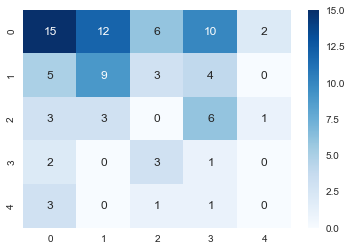

In [35]:
# sklearn.svm.NuSVC Nu-Support Vector Classification
# defaults: nu=0.5, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)
parameters = {
    'nu': [0.001,0.0025,0.005,0.0075,0.1], #other larger nu values is "not fleasible"
    'kernel': ['linear','poly','rbf'],
    'degree': [2,3,4,5,6],
    'gamma': [1e-5,1e-4,1e-3,1e-2,'auto'],
    'tol' : [1e-4],
    'decision_function_shape' : ['ovo','ovr'],

}


SVM = NuSVC()
grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train_009_pca, labels_train_009_pca)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train_009_pca, labels_train_009_pca)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test_009_pca)

checkmetrics(pred, labels_test, 'Nu-Support Vector Classification')


# Using PCA with Important Features (threshold >= 0.4) (XGB)

In [36]:
#svm.SVC  C-Support Vector Classification.
parameters ={
         'C': [0.005,0.01,0.05,0.1,0.25,0.5,0.75,1.0,2.0],
         'kernel': ['linear','poly','rbf'],
         'degree': [2,3,4,5,6],
        'gamma': [1e-3,1e-2,1,2,'auto'],
        'tol' : [1e-3],
        'decision_function_shape' : ['ovo','ovr'],
        }
SVM = svm.SVC()

grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train_04_pca, labels_train_04_pca)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train_04_pca, labels_train_04_pca)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test_04_pca)

checkmetrics(pred, labels_test, 'C-Support Vector Classification')

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 3234 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 4234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4998 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 5829 tasks      | elapsed:  5.5min


KeyboardInterrupt: 

In [ ]:
#LinearSVC Linear Support Vector Classification

parameters ={
#       'penalty' : ['l2'], #Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.
#       'loss' : ['squared_hinge'], #Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss.
#        dual' : ['False'], #Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features.
        'tol' : [1e-3],
        'C': [0.05,0.1,0.5,0.8,1.0,2.0,5.0,10.0,15.0],
        'multi_class'  : ['ovr','crammer_singer'],
        'random_state' : [42],
        'tol' : [1e-3],
        'max_iter' : [1000],
        }
SVM = LinearSVC()
grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train_04_pca, labels_train_04_pca)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train_04_pca, labels_train_04_pca)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test_04_pca)

checkmetrics(pred, labels_test, 'Linear Support Vector Classification')

In [ ]:
# sklearn.svm.NuSVC Nu-Support Vector Classification
# defaults: nu=0.5, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)
parameters = {
    'nu': [0.001,0.0025,0.005,0.0075,0.1], #other larger nu values is "not fleasible"
    'kernel': ['linear','poly','rbf'],
    'degree': [2,3,4,5,6],
    'gamma': [1e-5,1e-4,1e-3,1e-2,'auto'],
    'tol' : [1e-3],
    'decision_function_shape' : ['ovo','ovr'],

}


SVM = NuSVC()
grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train_04_pca, labels_train_04_pca)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train_04_pca, labels_train_04_pca)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test_04_pca)

checkmetrics(pred, labels_test, 'Nu-Support Vector Classification')
